In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from sklearn import tree
#import pydotplus
import collections
from IPython.display import Image  
#import pydotplus
from sklearn.tree import export_graphviz
import random

In [2]:
import copy

In [3]:
#%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#from sklearn.ensemble import RandomForestClassfier
from sklearn.feature_selection import SelectFromModel

In [38]:
df = pd.read_stata("Econ_484_data_final.dta")

In [39]:
df = df.drop("DAYSWAIT_CHRON", axis=1)

In [40]:
df = df.dropna(axis=0, how='any')

In [41]:
df['year'] = pd.DatetimeIndex(df["TX_DATE"]).year
df['month'] = pd.DatetimeIndex(df["TX_DATE"]).month
df = df.drop("TX_DATE", axis=1)

### Here I sort the dataframe by the Wait List length and put people into quintile buckets 0-4, 0 being the shortest quintile waitlist time and 4 being the longest wl time. I also create an ID indictator so I can identify people later on. 

In [25]:
 df['quint']=df.groupby('PERM_STATE')['DAYSWAIT_CHRON_KI'].transform(pd.qcut,5,labels=False)

In [26]:
df['id'] = df.index

### Now I am creating lists of the of the ID values for each quintile and then creating a list of 25 random people from our quintile sample. I can drop the quint column after I am done with this. 

In [27]:
rand_people_0_wl = df.query('quint == 0')['id'].tolist() 
sampling_0 = random.sample(rand_people_0_wl, k=25)
rand_people_1_wl = df.query('quint == 1')['id'].tolist()
sampling_1 = random.sample(rand_people_1_wl, k=25)
rand_people_2_wl = df.query('quint == 2')['id'].tolist()
sampling_2 = random.sample(rand_people_2_wl, k=25)
rand_people_3_wl = df.query('quint == 3')['id'].tolist()
sampling_3 = random.sample(rand_people_3_wl, k=25)
rand_people_4_wl = df.query('quint == 4')['id'].tolist()
sampling_4 = random.sample(rand_people_4_wl, k=25)

In [28]:
df = df.drop(['quint','id'], axis=1)

### These are the "Average" People Logan Created, I am adding them into the bottom of the data frame

In [42]:
df_ave = pd.read_excel('data_5.xlsx', sheet_name= 'Sheet2')
df_ave

NUM_PREV_TX  A1  A2  B1  B2  DR1  DR2 gender abo PERM_STATE  ...  PX_STAT  \
0            0   2  24  27  49    4   11      M   A         CA  ...        A   
1            0   2  24  35  50    7   11      M   O         CA  ...        A   
2            0   2  28  35  51    7   12      M   O         CA  ...        A   

   SHARE_TY  pstatus  ptime  AGE_GROUP  malig LT_ONE_WEEK_DON RECOV_OUT_US  \
0         3        0   2031          A      N               N            N   
1         3        0   2177          A      N               N            N   
2         3        0   1677          A      N               N            N   

   year month  
0  2006     7  
1  2006     7  
2  2010     7  

[3 rows x 50 columns]

In [43]:
frames=[df, df_ave]
df = pd.concat(frames).reset_index(drop=True)

In [44]:
# Average People are included
df.tail()


NUM_PREV_TX  A1  A2  B1  B2  DR1  DR2 gender abo PERM_STATE  ...  \
401746            0  36  68  53  57   11   13      M   O         IL  ...   
401747            1   2   2  55  57    4    7      F   O         IN  ...   
401748            0   2  24  27  49    4   11      M   A         CA  ...   
401749            0   2  24  35  50    7   11      M   O         CA  ...   
401750            0   2  28  35  51    7   12      M   O         CA  ...   

        PX_STAT  SHARE_TY  pstatus   ptime  AGE_GROUP  malig LT_ONE_WEEK_DON  \
401746        A         3        0     3.0          A      N               N   
401747        A         3        0    19.0          P      N               N   
401748        A         3        0  2031.0          A      N               N   
401749        A         3        0  2177.0          A      N               N   
401750        A         3        0  1677.0          A      N               N   

       RECOV_OUT_US  year month  
401746               2018    12  
401747               2018    10  
401748            N  2006     7  
401749            N  2006     7  
401750            N  2010     7  

[5 rows x 50 columns]

### Making Dummy Variables for Everything Cateogorical 


In [45]:
df = df.drop('PERM_STATE', axis=1)

In [46]:

dummy_columns = ['gender', 'abo', 'EXH_PERIT_ACCESS', 'EXH_VASC_ACCESS', 'PREV_TX', 'PREV_KI_TX',
                 'MALIG_TRR', 'txkid', 'ABO_DON','DON_TY', 'GENDER_DON',
                 'HOME_STATE_DON', 'ABO_MAT', 'GRF_STAT_KI', 'DWFG_KI', 'PREV_TX_ANY', 'PX_STAT',
                 'SHARE_TY', 'AGE_GROUP', 'malig', 'LT_ONE_WEEK_DON', 'RECOV_OUT_US', 'year', 'month']
funky_columns = ['TX_PROCEDUR_TY_KI']

In [47]:
df_non_dummy = df.drop(dummy_columns, axis=1)
#df_non_dummy

In [48]:
df_dummified = pd.get_dummies(df[dummy_columns])


In [49]:
df = df_non_dummy.merge(df_dummified, left_index=True, right_index=True)
df.shape
df.head()


NUM_PREV_TX  A1  A2  B1  B2  DR1  DR2  REM_CD  END_STAT  INIT_AGE  ...  \
0            0   1  26  38  44    1    4       4      4010      38.0  ...   
1            1   2  23  44  62    7   11       4      4010      43.0  ...   
2            0   3  25   7  27    1   13      15      4010      42.0  ...   
3            0   2  68  35  39    4    0       4      4010       9.0  ...   
4            0   1   2  62  27    3    4       4      4010      25.0  ...   

   AGE_GROUP_A  AGE_GROUP_P  malig_N  malig_U  malig_Y  LT_ONE_WEEK_DON_N  \
0            1            0        0        1        0                  1   
1            1            0        0        1        0                  1   
2            1            0        0        1        0                  1   
3            0            1        0        1        0                  1   
4            1            0        0        1        0                  1   

   LT_ONE_WEEK_DON_Y  RECOV_OUT_US_  RECOV_OUT_US_N  RECOV_OUT_US_Y  
0                  0              0               1               0  
1                  0              0               1               0  
2                  0              0               1               0  
3                  0              0               1               0  
4                  0              0               1               0  

[5 rows x 158 columns]

### Here is our Beautiful Random Forest Model, Need to cross validate and tune parameters. 

In [50]:
y_variable = 'DAYSWAIT_CHRON_KI'
X_variables = list(df.columns[df.columns != y_variable])
X = df[X_variables].to_numpy()
y = df[y_variable].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

forest = RandomForestRegressor(n_estimators=7)
model = forest.fit(X_train, y_train)

In [51]:
model.score(X_test,y_test)

0.8349462747275623

### I dont know what to do with this yet. Not sure how to fix it so we can read the feature importance graph. 

In [ ]:
sel = SelectFromModel(RandomForestRegress(n_estimators = 100))
sel.fit(X_train, y_train)

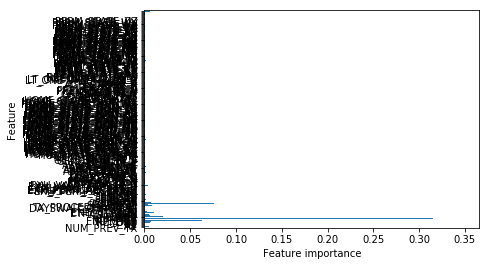

In [16]:
def plot_feature_importances_(model):
    n_features = X_test.shape[1]
    plt.barh(np.arange(n_features),model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),df.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_(model)

In [52]:
num_21 =  X[21,:].copy().reshape(1, -1)
num_21  = pd.DataFrame(num_21, columns = df[X_variables].columns)
num_21.iloc[0,:160]

NUM_PREV_TX             0.0
A1                     11.0
A2                     28.0
B1                      8.0
B2                     44.0
DR1                     3.0
DR2                     4.0
REM_CD                  4.0
END_STAT             4010.0
INIT_AGE               43.0
ethnicity               0.0
ethcat                  1.0
region                  4.0
RB1                     8.0
npkid                   0.0
AGE_DON                20.0
ETHCAT_DON              1.0
END_STAT_KI          4010.0
age                    43.0
GTIME_KI             1190.0
GSTATUS_KI              1.0
TX_PROCEDUR_TY_KI     102.0
pstatus                 1.0
ptime                1190.0
SHARE_TY                3.0
year                 1994.0
month                   4.0
gender_F                0.0
gender_M                1.0
abo_A                   0.0
                      ...  
HOME_STATE_DON_ZZ       0.0
ABO_MAT_1               0.0
ABO_MAT_1               1.0
ABO_MAT_                0.0
ABO_MAT_1           

### This is where the magic happens!

In [ ]:
state_names = ['AK','AL','AR','AS','AZ','CA','CO','CT','DC','DE','FL','GA',
               'GU','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME',
               'MI','MN','MO','MP','MS','MT','NA','NC','ND','NE','NH','NJ',
               'NM','NV','NY','OH','OK','OR','PA','PR','RI','SC','SD','TN',
               'TX','UT','VA','VI','VT','WA','WI','WV','WY','ZZ']

### This is a for loop that takes the random sample from quintile 0 and predicts their waitlist time changing the state they live in each time for all states and territories. It puts this info into a data frame, wl_times_0 and then we can take summary stats on this dataframe. W

### When I increase the sample size to 100 or 1,000 I am not quite sure what summary stats to report on that right now, maybe the distribution of waitlist variances? See how

In [64]:
wl_times_0 = pd.DataFrame()

In [65]:
List = []
for j in sampling_0:
     obs = (X[j,:].copy().reshape(1,-1))
     List.append(model.predict(obs))

In [66]:
#List = np.asarray(List)  
wl_times_0['National'] = List


In [67]:
wl_times_0['National']= wl_times_0['National'].asarray

National
0               [1355.0]
1                [270.0]
2   [211.42857142857142]
3    [757.2857142857143]
4   [117.85714285714286]
5    [619.7142857142857]
6   [30.428571428571427]
7   [145.57142857142858]
8   [328.42857142857144]
9   [196.42857142857142]
10                [19.0]
11   [81.28571428571429]
12               [221.0]
13  [402.57142857142856]
14  [403.57142857142856]
15  [508.85714285714283]
16  [2424.5714285714284]
17  [1905.2857142857142]
18  [2223.4285714285716]
19   [747.1428571428571]
20               [107.0]
21  [185.28571428571428]
22  [115.57142857142857]
23  [141.57142857142858]
24   [1067.857142857143]

In [53]:
wl_times_0 = pd.DataFrame()


List = []
for j in sampling_0:
     obs = (X[j,:].copy().reshape(1,-1))
     List.append(model.predict(obs))
        
List = np.asarray(List)  
wl_times_0[j] = List


#wl_times_0.describe()

Exception: Data must be 1-dimensional

In [ ]:
wl_times_1 = pd.DataFrame()



List = []
for j in sampling_1:
     obs = (X[j,:].copy().reshape(1,-1))
     List.append(model.predict(obs))
        
List = np.asarray(List)  
wl_times_1[j] = List


wl_times_1.describe()

In [ ]:
wl_times_2 = pd.DataFrame()



List = []
for j in sampling_2:
     obs = (X[j,:].copy().reshape(1,-1))
     List.append(model.predict(obs))
        
   
        
List = np.asarray(List)  
wl_times_2[j] = List


wl_times_2.describe()

In [ ]:
wl_times_3 = pd.DataFrame()



List = []
for j in sampling_3:
     obs = (X[j,:].copy().reshape(1,-1))
     List.append(model.predict(obs))
    
        
List = np.asarray(List)  
wl_times_3[j] = List


wl_times_3.describe()

In [ ]:
wl_times_4 = pd.DataFrame()



List = []
for j in sampling_4:
     obs = (X[j,:].copy().reshape(1,-1))
     List.append(model.predict(obs))
        
List = np.asarray(List)  
wl_times_4[j] = List


wl_times_4.describe()

### Now we repeat this process for the "average people"
### They are at the end of the data frame, they are ordered short, medium, long. 

In [78]:
wl_times_ave_peeps = pd.DataFrame()

ave_peep_id = [401748,401749,401750]

List = []
for j in ave_peep_id:
     obs = (X[j,:].copy().reshape(1,-1))
     List.append(model.predict(obs))
    
List = np.asarray(List)  
wl_times_ave_peeps[j] = List


wl_times_ave_peeps.describe()